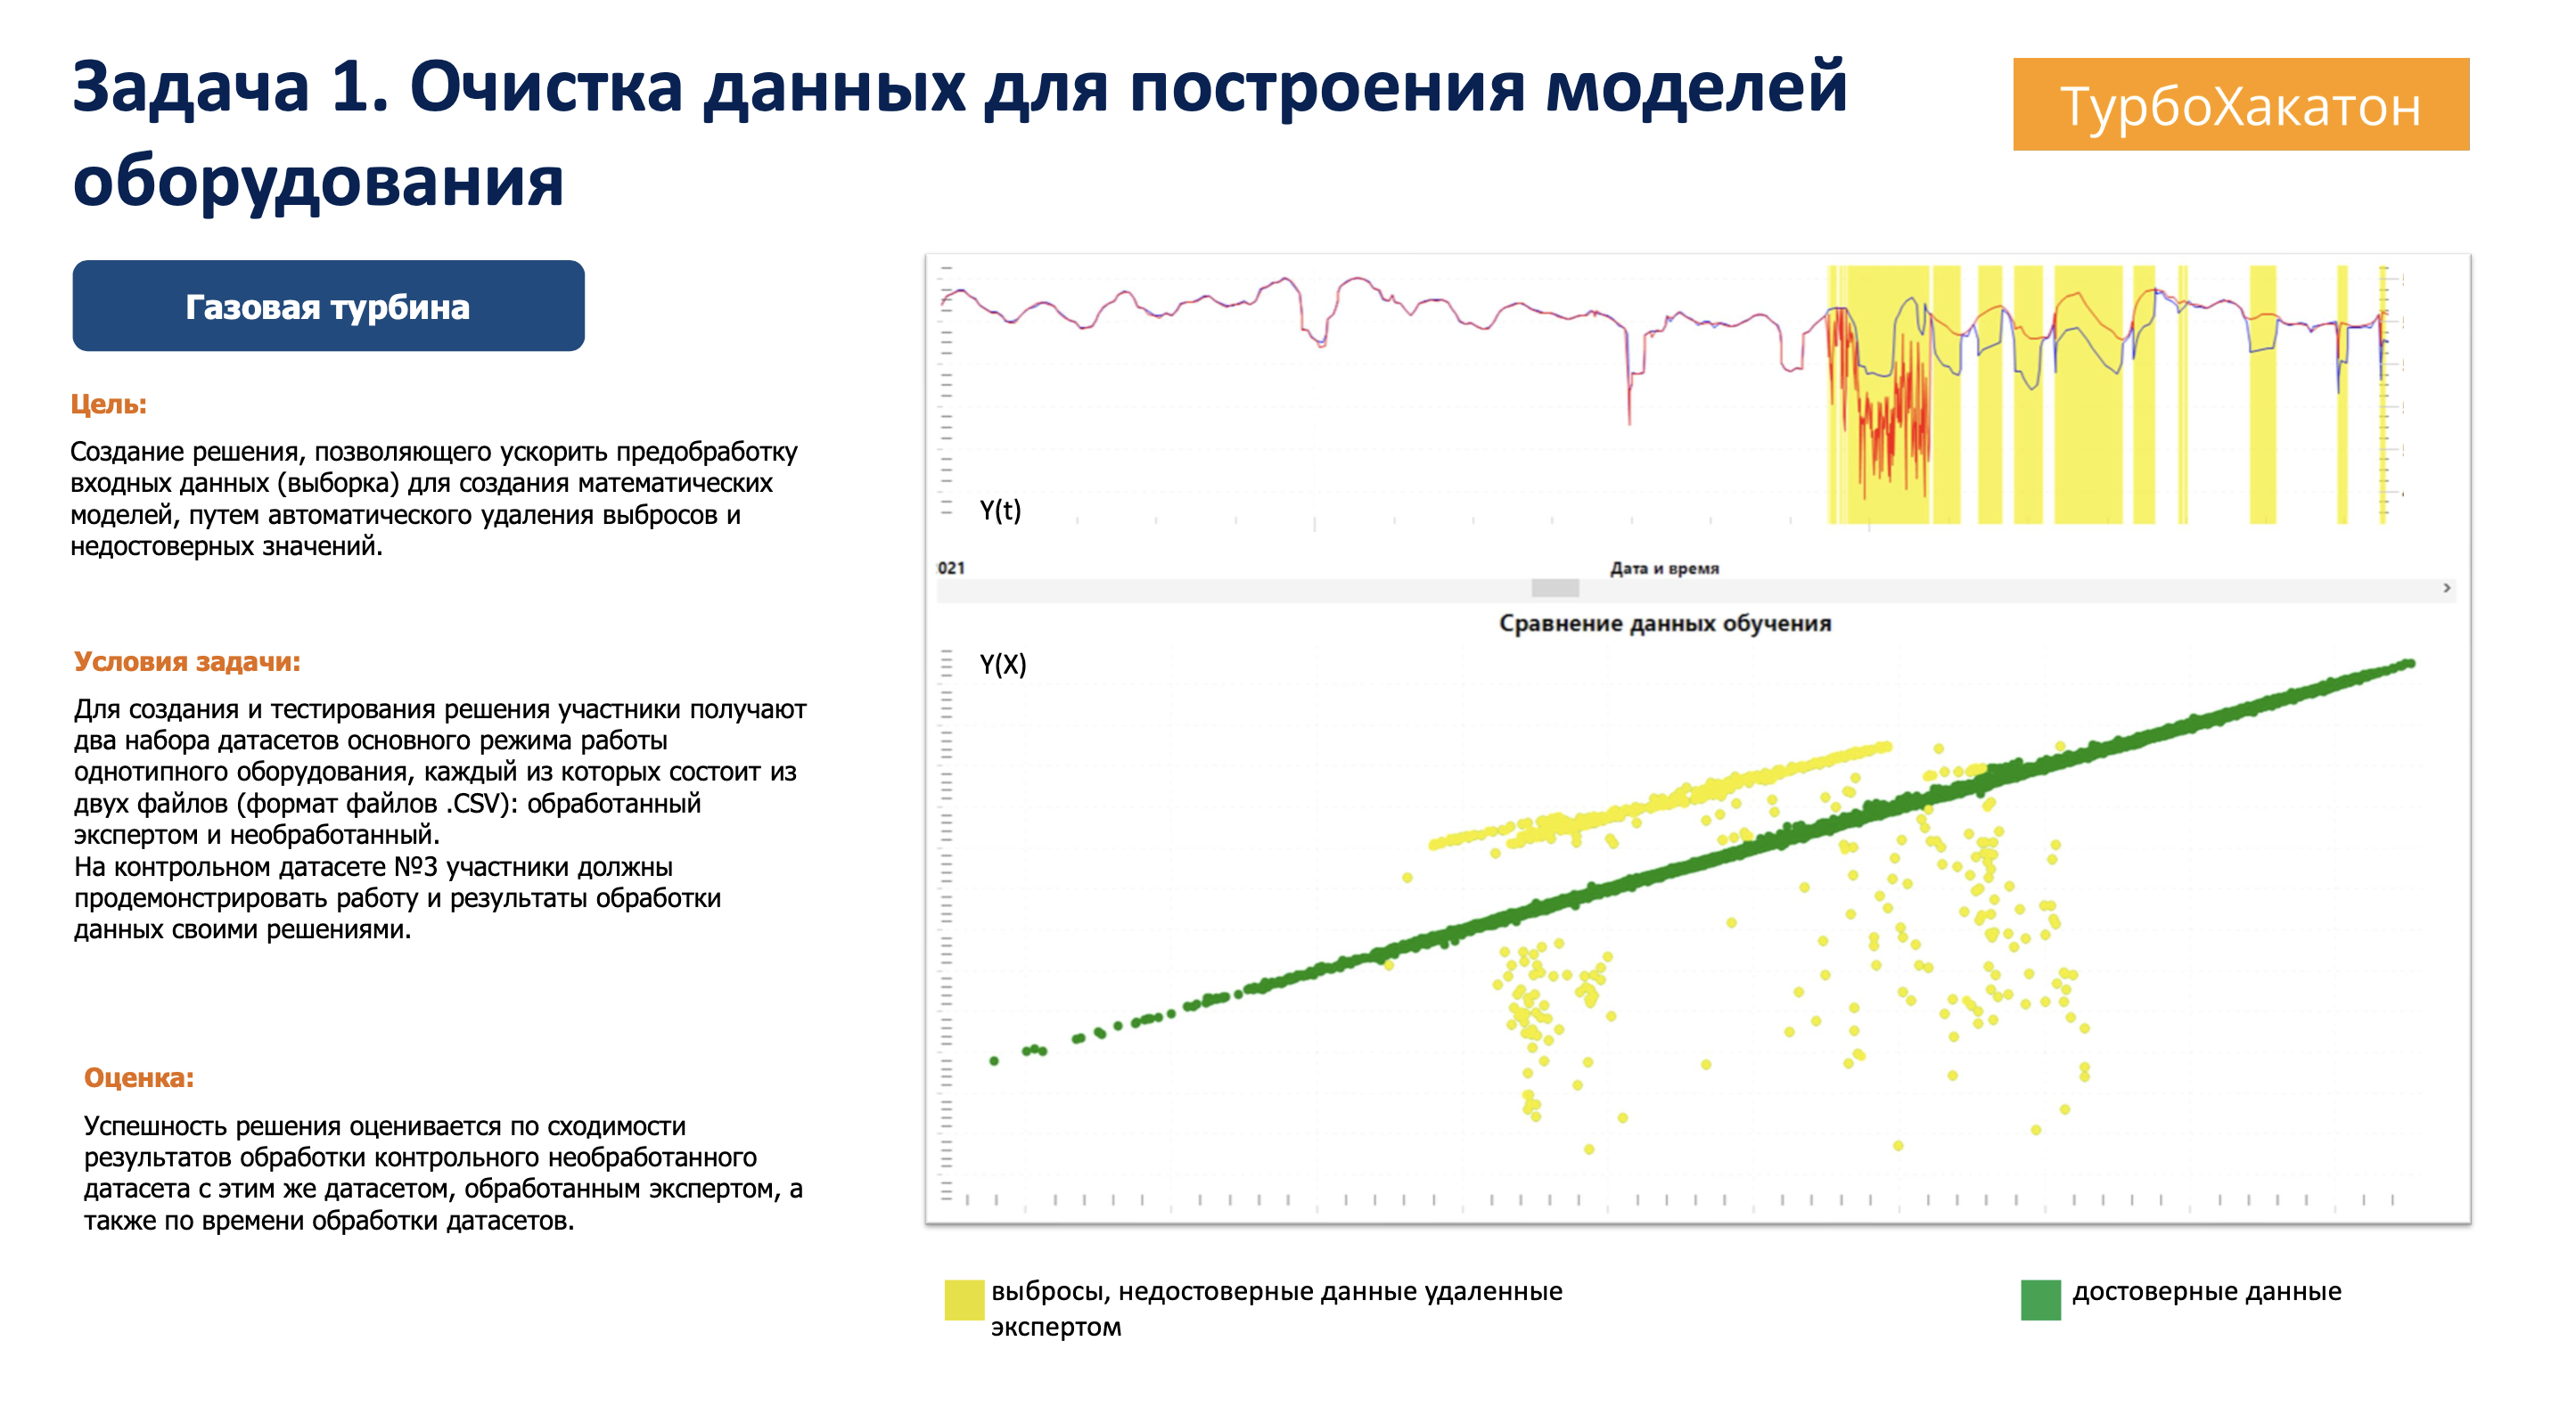

In [1]:
from IPython.display import Image, display

display(Image("pic_task1.png"))


Курс по временным рядам от сбера
https://github.com/korowood/ts_winter/blob/master/week_1/transformations.ipynb


Примеры с каггла
https://www.kaggle.com/code/kellibelcher/time-series-forecasting-arima-ets-boosting

https://www.kaggle.com/code/lonnieqin/tps-22-03-with-lstm-including-moving-average

https://www.kaggle.com/code/packinman/tps-mar-2022-automl-pycaret-regression

1. Понять и выделить метрики по которым сравниваются 2 датасета

        pandas.testing.assert_frame_equal ??

2. Найти методы поиска аномалий на временных рядах

        clustering


3. По каким то фичам значения удалены, а по каким то заменены. Почему? На какое значение? - не заменены

In [8]:
import pandas as pd
import os
import seaborn as sns
import matplotlib.pyplot as plt
import plotly
import numpy as np
from plotting import plot_ts

from statsmodels.graphics import tsaplots
from statsmodels.stats import diagnostic
from statsmodels.tsa.stattools import adfuller

from tsfresh import extract_features
from tsfresh.utilities.dataframe_functions import impute

In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
os.listdir("../task_1")

['pic_task1.png',
 '.DS_Store',
 'eda_task1.ipynb',
 'plotting.py',
 'Задача 1. Датасет 1. Тренировочный неразмеченный.xlsx',
 'modeling.ipynb',
 'Задача 1. Датасет 2. Тестовый неразмеченный.xlsx',
 '__pycache__',
 'model.py',
 'README.md',
 'modeling_2.ipynb',
 'Задача 1. Датасет 2. Тестовый размеченный.xlsx',
 'Задача 1. Датасет 1. Тренировочный размеченный.xlsx',
 'catboost_info']

In [5]:
data1_unlabled = pd.read_excel("Задача 1. Датасет 1. Тренировочный неразмеченный.xlsx", index_col='Параметр')
data1_labled = pd.read_excel("Задача 1. Датасет 1. Тренировочный размеченный.xlsx", index_col='Параметр')

In [52]:
data2_unlabled = pd.read_excel("Задача 1. Датасет 2. Тестовый неразмеченный.xlsx", index_col='Параметр')
data2_labled = pd.read_excel("Задача 1. Датасет 2. Тестовый размеченный.xlsx", index_col='Параметр')

In [61]:
print(f"Размерность исходного датасета: {data1_unlabled.shape}")
print(f"Размерность обработанного датасета: {data1_labled.shape}")
print(f"Процент удаленных наблюдений: {np.round(100 - data1_labled.shape[0]/data1_unlabled.shape[0] * 100, 3)}")

Размерность исходного датасета: (37339, 44)
Размерность обработанного датасета: (36816, 44)
Процент удаленных наблюдений: 1.401


In [6]:
# plt.figure(figsize=(10, 12))
# sns.lineplot(data=data_unlabled, x="Параметр", y="х001")
# sns.lineplot(data=data_labled, x="Параметр", y="х001")

In [23]:
def featuresTSFresh(data):

    ## список фич (см. документацию по TSFresh: https://media.readthedocs.org/pdf/tsfresh/latest/tsfresh.pdf)
    extraction_settings =\
        {
            ## признак: параметр
            "maximum": None,
            "mean": None,
            "minimum": None,
            "median": None,
            "standard_deviation": None,
            "binned_entropy": [{"max_bins" : 10}],
            "count_above_mean": None,
            "count_below_mean": None,
            "first_location_of_maximum": None,
            "first_location_of_minimum": None,
            "mean_change": None,
            "sum_values": None,
            "kurtosis": None,
            "skewness": None,
            "abs_energy": None
        }

    ## извлечение фич из данных
    featuresDF = extract_features(
        data,
        column_id="variable",  ## номер временного ряда
        column_sort="Параметр", ## ось времени
        default_fc_parameters=extraction_settings, ## список фич, которые хотим извлечь
        impute_function=impute                     ## заменить все inf и NaN
    )

    ## вытаскиваем колонку id из индекса
    featuresDF = featuresDF.reset_index()

    return featuresDF

print("Calculating unlabled data ...")
features_ul = featuresTSFresh(pd.melt(data1_unlabled, ignore_index=False).reset_index())
print("Finish! GJ")
print("Calculating labled data ...")
features_l = featuresTSFresh(pd.melt(data1_labled, ignore_index=False).reset_index())

Calculating unlabled data ...


Feature Extraction: 100%|██████████| 22/22 [00:04<00:00,  5.19it/s]


Finish! GJ
Calculating labled data ...


Feature Extraction: 100%|██████████| 22/22 [00:03<00:00,  6.94it/s]


In [33]:
FEAT = 'х005'

In [38]:
stats_df = pd.DataFrame()
stats_df['Исходный'] = features_ul[features_ul['index'] == FEAT].T
stats_df['Итоговый'] = features_l[features_l['index'] == FEAT].T


In [39]:
tmp = data1_unlabled[FEAT]
tmp1 = data1_labled[FEAT]
print(stats_df)
plot_ts(tmp, tmp1)

                                              Исходный            Итоговый
index                                             х005                х005
value__maximum                                  623.17              617.25
value__mean                                 570.420289          570.729444
value__minimum                                  33.235              544.39
value__median                                   562.84              562.86
value__standard_deviation                    21.410588           16.451816
value__binned_entropy__max_bins_10            0.697459            1.837454
value__count_above_mean                        15082.0             14747.0
value__count_below_mean                        22257.0             22069.0
value__first_location_of_maximum              0.284742            0.286587
value__first_location_of_minimum              0.726211            0.690434
value__mean_change                           -0.000274            -0.00087
value__sum_values        

Loading BokehJS ...

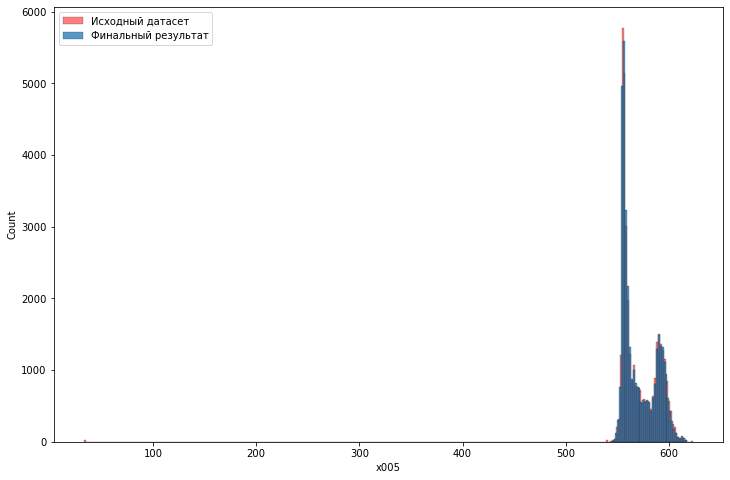

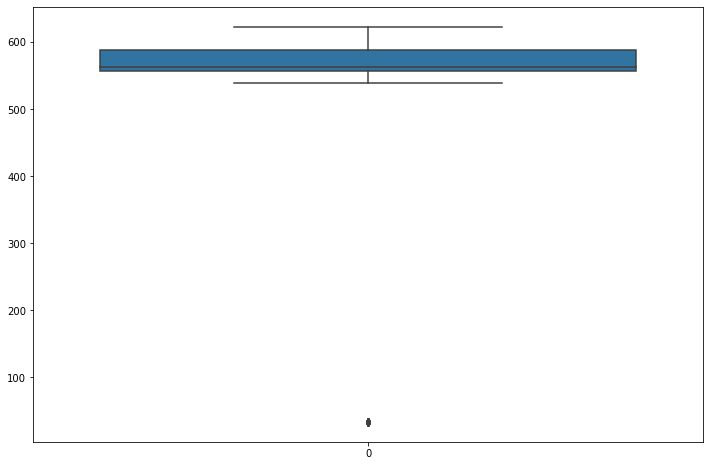

In [76]:

plt.figure(figsize=(12, 8))
sns.histplot(tmp, alpha=0.5, color="red")
sns.histplot(tmp1)
plt.legend(labels=['Исходный датасет', 'Финальный результат']);
plt.show()

plt.figure(figsize=(12, 8))
sns.boxplot(data=tmp)
plt.show()

In [110]:
from plotly.offline import init_notebook_mode, iplot, plot
import plotly.express as px
import plotly as py
import plotly.io as pio
pio.renderers.default = "vscode"
init_notebook_mode(connected=True)

In [73]:
tmp = data_unlabled[:100]
# pd.pivot(tmp, index=[tmp.columns, tmp.index], columns=tmp.values)

In [77]:
tmp

,х001,х002,х005,х006,х007,х008,х009,х010,х011,х012,...,х039,х040,х041,х042,х043,х044,х045,х046,х047,х048
Параметр,,,,,,,,,,,,,,,,,,,,,
2021-03-24 13:30:00,554.01,546.45,568.66,553.95,550.21,549.53,564.10,564.59,555.75,553.00,...,545.17,534.33,531.89,533.32,564.66,554.75,539.90,537.91,562.42,566.70
2021-03-24 13:40:00,566.22,557.23,583.57,567.53,564.84,560.93,580.80,580.53,570.74,563.59,...,566.10,549.94,547.08,547.60,578.51,572.07,553.96,550.94,571.90,578.61
2021-03-24 13:50:00,577.64,566.55,590.45,576.19,573.11,571.31,590.91,589.67,579.19,569.13,...,577.83,560.46,556.89,555.97,585.74,581.30,561.09,560.34,577.21,577.46
2021-03-24 14:00:00,586.00,572.80,599.18,585.74,580.65,578.99,596.22,597.53,585.06,574.26,...,591.73,569.11,565.92,564.06,589.19,591.20,569.13,568.94,581.37,585.81
2021-03-24 14:10:00,588.59,573.98,600.51,590.21,583.39,582.58,594.09,594.99,586.70,571.53,...,597.62,573.98,569.60,567.60,584.83,595.38,572.04,571.79,583.09,588.49
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-03-25 05:20:00,559.08,563.60,566.78,572.62,579.31,579.46,585.48,584.68,580.52,582.10,...,572.36,568.84,565.86,568.33,572.40,564.70,560.58,561.45,564.90,563.45
2021-03-25 05:30:00,558.68,563.10,566.54,571.94,578.85,579.32,585.15,584.70,580.19,582.10,...,572.11,568.52,565.54,568.25,572.03,564.65,560.33,560.88,564.44,563.00
2021-03-25 05:40:00,558.67,562.87,566.57,572.22,578.81,579.07,585.32,584.90,580.17,582.05,...,572.28,568.57,565.50,568.08,572.10,564.80,560.20,560.98,564.56,562.95


In [92]:
tmp.reset_index(inplace=True)

In [94]:
tmp_ = pd.melt(tmp, id_vars=['Параметр'])

In [112]:
px.line(tmp_,
              x='Параметр',
              y='value',
              animation_frame='variable')
